In [2]:
# 设置数据集名称，对应 https://xenabrowser.net/datapages/ 中缩写
dataset_name =  ['LUAD', 'LUSC']
# 设置俩： ['LUAD', 'LUSC']
# 更多更多也行
# 单一个： ['LUAD'] 
# All possible Value:
# ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
method = 'normal' # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'
loglevel = ''
# loglevel = 'debug'

balance_input = 'true' # or true 
rate1 = 0.0 # 在0里面混多少不是这个的1

In [3]:
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from sklearn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
from imblearn.over_sampling import SMOTE, SMOTEN
sm = SMOTEN(random_state=42)
from multiprocessing import Pool, cpu_count
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from IPython.display import display, HTML
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

In [4]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] + [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t

def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df

In [5]:
# balance_data
def getStatus0data():
    Status0data = pd.DataFrame()
    Status1data = pd.DataFrame()
    for datasets in ['LAML','ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC','LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD','TGCT','THYM','THCA','UCS']:
        if datasets in dataset_name:
            continue
        try:
            # use download_and_parse_data to download the data
            dataframe = download_and_parse_data(datasets)
            # 把Status为0的dataframe赋值给Status0data
            Status0data = pd.concat([Status0data, dataframe[dataframe['Status'] == 0]])
            Status1data = pd.concat([Status1data, dataframe[dataframe['Status'] == 1]])
        except:
            print('Error:', datasets)
            continue

    # 混入对应比例的1
    # Status0data = pd.concat([Status0data, Status1data.sample(len(Status0data)*rate1/(1-rate1))])
    # int is needed
    Status0data = pd.concat([Status0data, Status1data.sample(n=int(len(Status0data)*rate1/(1-rate1)),random_state=42)])
    # 把所有的label 都设为0
    Status0data['Status'] = 0
    # 保存0的dataframe为pkl文件
    pkl_file_path = './datasets/Status0data.pkl'
    Status0data.to_pickle(pkl_file_path)

    return Status0data

def balance_data(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly sample from Status=0 data and concatenate
        Status0data = getStatus0data()
        balanced_data = pd.concat([current1, Status0data.sample(n=(len(current1) - len(current0)),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data

def balance_data2(Currentdata):
    # Get the count of Status=0 and Status=1
    current1 = Currentdata[Currentdata['Status'] == 1]
    current0 = Currentdata[Currentdata['Status'] == 0]
    
    if len(current0) > len(current1):
        print('0 is more than 1')
        # No need to balance, return the original DataFrame
        return Currentdata
    else:
        print('1 is more than 0')
        # If 1 is more, randomly remove some Status=1 data and concatenate
        balanced_data = pd.concat([current0, current1.sample(n=len(current0),random_state=42)])
        print('Currentdata.shape:', balanced_data.shape)
        return balanced_data

In [6]:
if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))

# if balance_input, we need to balance the data using different datasets.
if balance_input == 'true':
    df_transposed = balance_data(df_transposed)
    
train_data = df_transposed.apply(pd.to_numeric)

1 is more than 0
Currentdata.shape: (1895, 1882)


In [7]:
def calculate_correlation(train_data):
    status = train_data.iloc[:, 0]
    other_columns = train_data.iloc[:, 1:]
    correlations = {}

    for column in other_columns.columns:
        data = other_columns[column]
        corr, _ = pearsonr(status, data)
        if not pd.isnull(corr):
            correlations[column] = corr

    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:] 

    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column', 'Correlation'])
    correlation_df = correlation_df.rename(columns={'Column': 'gene_id'})
    correlation_df.to_csv('correlation_results.csv', index=False)
    print("Correlation results saved to correlation_results.csv")
calculate_correlation(train_data)

def plot_score_distribution(ax, y_score, final_Status, gene_name):                                # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_Status, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title(gene_name)
    ax.set_xlabel('Sample number')
    ax.set_ylabel('score')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数


Correlation results saved to correlation_results.csv


Size of test data: 1137


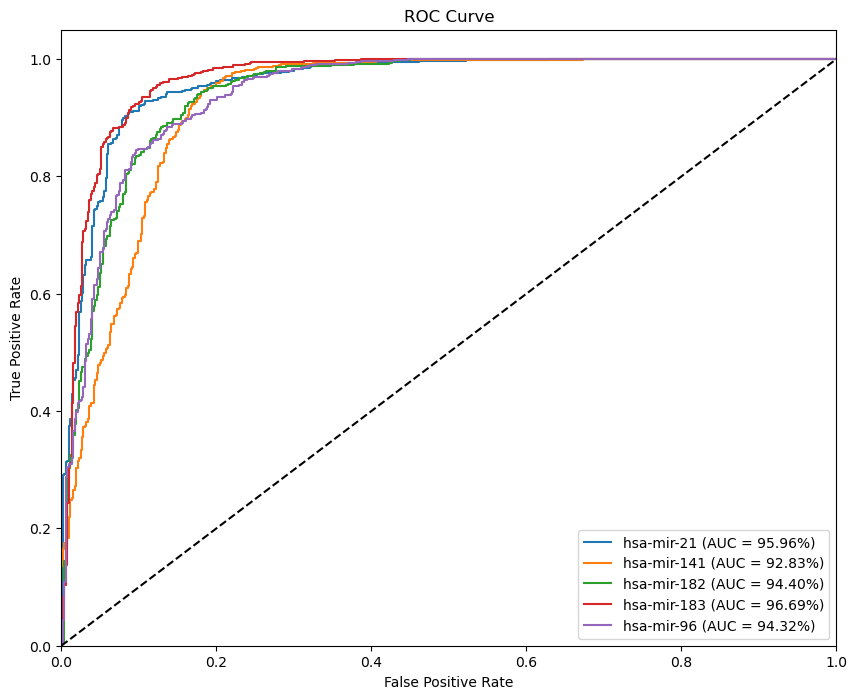

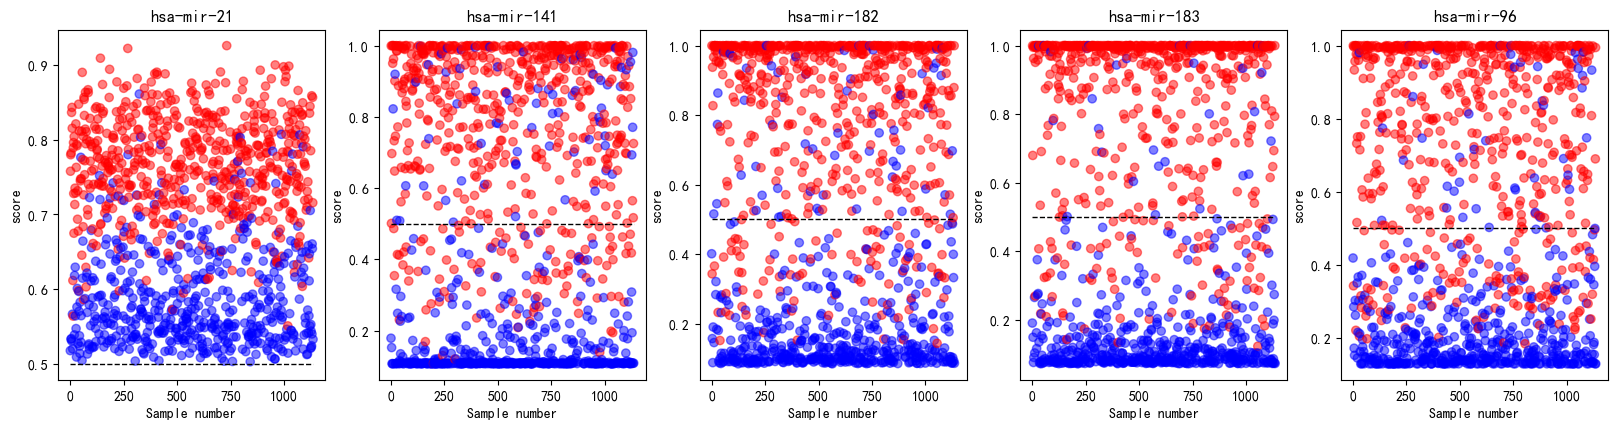

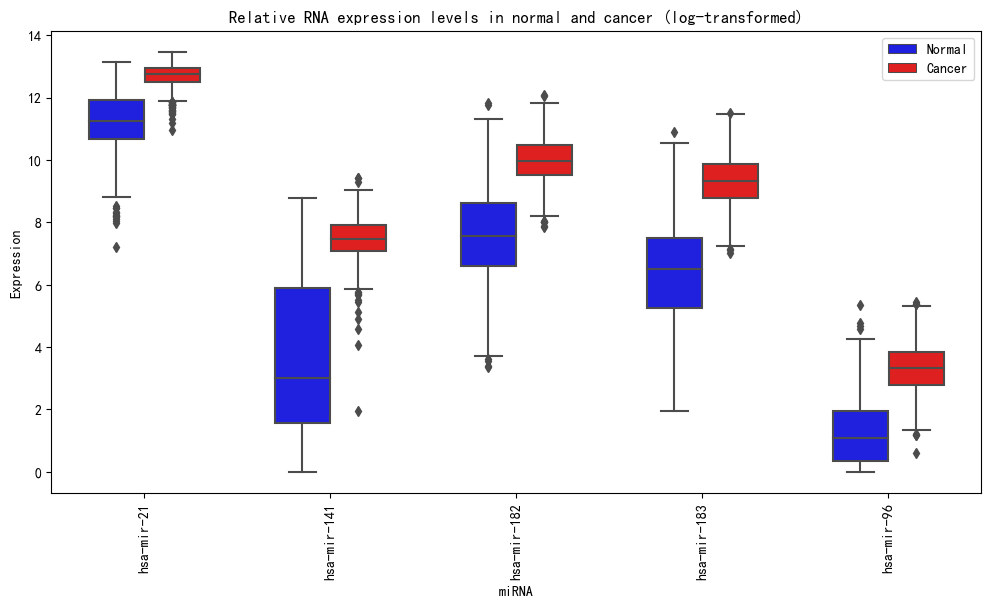

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Assuming the data is loaded into a DataFrame
# Replace 'your_data.csv' with the path to your CSV file
# df = pd.read_csv('your_data.csv')
df = train_data  # Replace with actual data loading

# Separate features and target
X = df.drop(columns=['Status'])
y = df['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

# Calculate AUC for each miRNA
miRNA_columns = df.columns[2:]  # Adjust index if necessary
auc_values = {}
print(f"Size of test data:", len(X_test))
for miRNA in miRNA_columns:
    model = LinearRegression()
    
    # Use the specific miRNA column for training and testing
    train_data1 = X_train[[miRNA]]
    
    test_data = X_test[[miRNA]]
    
    model.fit(train_data1, y_train)
    y_pred_prob = model.predict(test_data)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    roc_auc = auc(fpr, tpr)
    auc_values[miRNA] = roc_auc

# Get the top 10 miRNAs with the highest AUC values
#top_10_miRNAs = sorted(auc_values, key=auc_values.get, reverse=True)[:10]
#print("Top 10 miRNAs with highest AUC values:\n", top_10_miRNAs)
#top_10_miRNAs = ['hsa-mir-99b','hsa-mir-200c','hsa-mir-125a','hsa-mir-1292','hsa-mir-374a']
top_10_miRNAs = ['hsa-mir-21','hsa-mir-141','hsa-mir-182','hsa-mir-183','hsa-mir-96']


# Plotting function for ROC curves
def plot_roc_curve(df, miRNA_columns, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(10, 8))
    roc_data = []
    for miRNA in miRNA_columns:
        model = LinearRegression()
        train_data2 = X_train[[miRNA]]
        test_data = X_test[[miRNA]]
        
        model.fit(train_data2, y_train)
        y_pred_prob = model.predict(test_data)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{miRNA} (AUC = {100*roc_auc:.2f}%)')
        roc_data.append(pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'miRNA': miRNA}))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    # 合并所有miRNA的ROC数据
    roc_data_df = pd.concat(roc_data)
    
    # 保存到CSV文件
    roc_data_df.to_csv('roc_data.csv', index=False)
    axs = plt.subplots(1, 5, figsize=(20, 10))
    n = 0
    data_df = pd.DataFrame(columns=['Gene_Name', 'Sample_Number', 'Score', 'Final_Status'])

    for n, mir in enumerate(top_10_miRNAs):
        model = LogisticRegression()
        train_data3 = X_train[[mir]]
        test_data = X_test[[mir]]

        model.fit(train_data3, y_train)
        y_pred_prob = model.predict_proba(test_data)[:, 1]

        # 将预测概率和真实标签转换为DataFrame
        temp_df = pd.DataFrame({
            'Gene_Name': [mir] * len(y_pred_prob),
            'Sample_Number': range(len(y_pred_prob)),
            'Score': y_pred_prob,
            'Final_Status': y_test
        })

        # 将临时DataFrame添加到主DataFrame中
        data_df = pd.concat([data_df, temp_df], ignore_index=True)
        # iit a new ax
        ax = plt.subplot(2, 5, n + 1)
        n += 1
        plot_score_distribution(ax, y_pred_prob, y_test, mir)
    data_df.to_csv('miRNA_scores.csv', index=False)

def plot_miRNA_expression(df, miRNA_columns,output_csv='miRNA_expression_data.csv'):
    # Apply log transformation to the expression values
    df_log_transformed = df.copy()
    for col in miRNA_columns:
        df_log_transformed[col] = np.log1p(df[col])
    
    df_melted = df_log_transformed.melt(id_vars=['Status'], value_vars=miRNA_columns, 
                                        var_name='miRNA', value_name='Expression')
    df_melted.to_csv(output_csv, index=False)
    plt.figure(figsize=(12, 6))
    # Adjust the palette to match the unique values in 'Status'
    unique_status = df['Status'].unique()
    palette = {status: color for status, color in zip(unique_status, ['red', 'blue'])}  # Swap colors to match 'Normal' = blue and 'Cancer' = red
    sns.boxplot(x='miRNA', y='Expression', hue='Status', data=df_melted, palette=palette, width=0.6)
    plt.title('Relative RNA expression levels in normal and cancer (log-transformed)')
    plt.xticks(rotation=90)
    
    # Update legend to use custom labels
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Normal', 'Cancer'], title=None)  # Remove title and set labels

    plt.show()

def plot_best_confusion_matrix(y_test, y_pred_prob, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    # Calculate the best threshold
    J = tpr - fpr
    best_threshold = thresholds[np.argmax(J)]
    
    # Convert probabilities to class labels using the best threshold
    y_pred_class = (y_pred_prob >= best_threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)
    
    # Calculate accuracy for each class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Calculate precision and recall for positive and negative classes
    precision_positive = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall_positive = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    precision_negative = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    recall_negative = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    # Calculate overall accuracy
    overall_accuracy = np.trace(cm) / np.sum(cm)
    
    # Create a 3x3 matrix to display class accuracies, precision, recall, and overall accuracy
    extended_cm = np.zeros((3, 3), dtype=float)
    extended_cm[:2, :2] = cm

    extended_cm[1, 2] = recall_positive * 100     # Positive Recall (Sensitivity)
    
    extended_cm[2, 1] = precision_positive * 100
    extended_cm[0, 2] = recall_negative * 100     # Negative Recall (Specificity)
    extended_cm[2, 0] = precision_negative * 100
    extended_cm[2, 2] = overall_accuracy * 100    # Overall Accuracy
    
    # Plotting the extended confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(extended_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False,
                annot_kws={"size": 20, "fontname": "Arial"},
                xticklabels=['Actual Negative', 'Actual Positive', 'Accuracy'],
                yticklabels=['Predicted Negative', 'Predicted Positive', 'Accuracy'])
    
    # Add '%' symbol to percentage cells
    for i in range(3):
        for j in range(3):
            if i == 2 or j == 2:
                text = plt.gca().texts[i*3+j]
                text.set_text(f"{text.get_text()}%")
                text.set_color('black')  # Set text color to black for white cells
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title} (Threshold: {best_threshold:.2f}, AUC: {roc_auc:.2f})')
    plt.show()


colors = [(1, 1, 0.95), # 深红
(1, 0.741, 0.741), # 浅粉
(1, 0.498, 0.412)] # 白色
custom_cmap = LinearSegmentedColormap.from_list('custom_pinkish', colors)
def plot_silent_confusion_matrix(y_test, y_pred_prob, miRNA_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculate the best threshold
    J = tpr - fpr
    best_threshold = thresholds[np.argmax(J)]
    
    # Convert probabilities to class labels using the best threshold
    y_pred_class = (y_pred_prob >= best_threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)
    
    # Create a 3x3 matrix to display class accuracies, precision, recall, and overall accuracy
    extended_cm = np.zeros((3, 3), dtype=float)
    extended_cm[:2, :2] = cm
    
    # Create a mask to hide the last row and column (which hold the accuracy metrics)
    mask = np.ones_like(extended_cm)
    mask[:2, :2] = False  # Show only the actual confusion matrix cells
    
    # Plotting the extended confusion matrix without annotations in the masked areas
    plt.figure(figsize=(8, 6))
    sns.heatmap(extended_cm, annot=False, fmt='.1f', cmap=custom_cmap,  # 使用 'viridis' 色彩映射并显示颜色条
                xticklabels=False, yticklabels=False, mask=mask,cbar=True,
                cbar_kws={'ticks': []})
    
    plt.gca().set_axis_off()  # Hide axis and borders
    
    # Save the plot to desktop with the miRNA name in the file name
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    save_path = os.path.join(desktop_path, f'mir_{miRNA_name}_beautiful.png')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to free memory


# Plot the ROC curves for the top 10 miRNAs
plot_roc_curve(df, top_10_miRNAs, X_train, X_test, y_train, y_test)

# Plot the expression levels for the top 10 miRNAs
plot_miRNA_expression(df, top_10_miRNAs)


for miRNA in top_10_miRNAs:
    model = LinearRegression()
    train_data4 = X_train[[miRNA]]
    test_data = X_test[[miRNA]]
    
    model.fit(train_data4, y_train)
    y_pred_prob = model.predict(test_data)
    
    # Save each confusion matrix with the miRNA name
    #plot_best_confusion_matrix(y_test, y_pred_prob, title=f'Confusion Matrix for {miRNA}')
    plot_silent_confusion_matrix(y_test, y_pred_prob, miRNA_name=miRNA)



In [9]:
# Count the occurrences of each value in the 'Status' column
status_counts = df['Status'].value_counts()

# Display the counts
print(status_counts)


1    994
0    901
Name: Status, dtype: int64


In [10]:
# 保存 df 为 CSV 文件
#df.to_csv('miRNA_expression_data.csv', index=False)


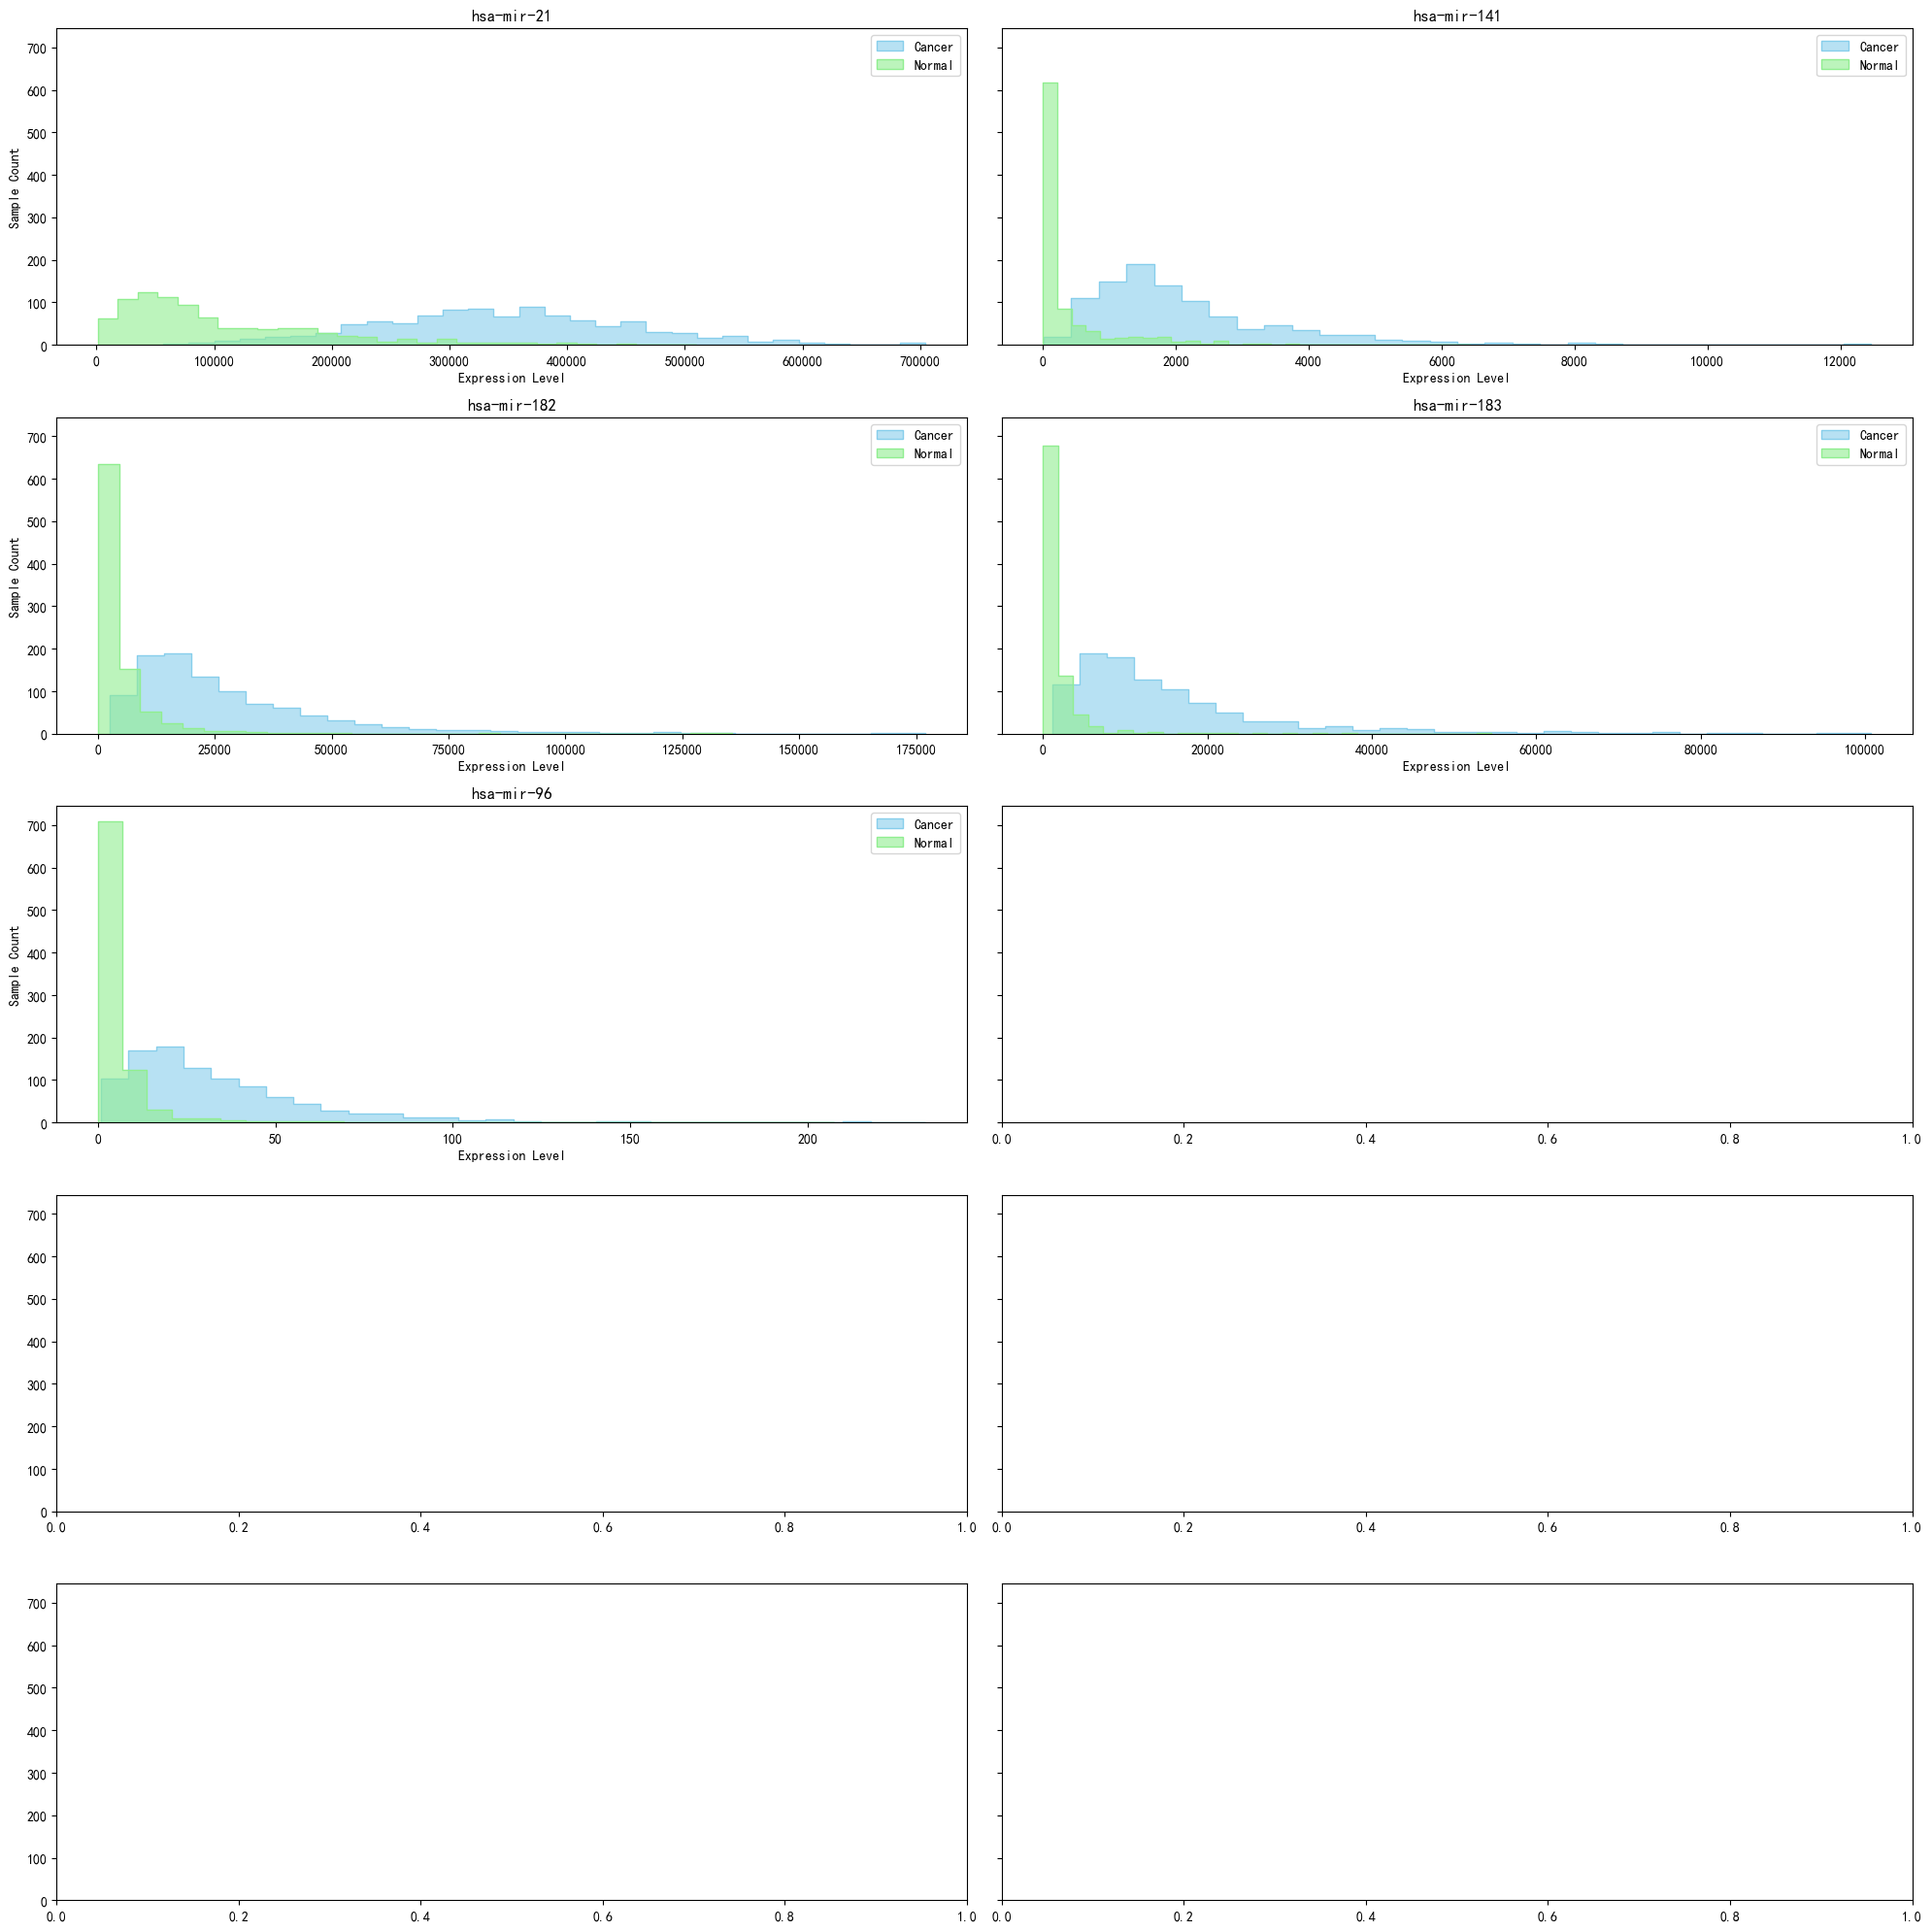

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the data is loaded into a DataFrame
# df = pd.read_csv('your_data.csv')
df = train_data  # Replace with actual data loading

# Separate features and target
miRNA_columns = df.columns[1:]  # Assuming the first column is 'Status'

# Plotting function for miRNA expression levels
def plot_miRNA_expression2(df, miRNA_columns):
    fig, axes = plt.subplots(5, 2, figsize=(20, 20), sharey=True)
    axes = axes.flatten()
    
    colors = ['skyblue', 'lightgreen']  # 新颜色方案
    labels = ['Cancer', 'Normal']  # 样本类型标签
    
    for idx, miRNA in enumerate(miRNA_columns):
        ax = axes[idx]
        cancer = df[df['Status'] == 1][miRNA]
        normal = df[df['Status'] == 0][miRNA]
        
        sns.histplot(cancer, bins=30, kde=False, ax=ax, color=colors[0], label=labels[0], alpha=0.6, element="step", fill=True)
        sns.histplot(normal, bins=30, kde=False, ax=ax, color=colors[1], label=labels[1], alpha=0.6, element="step", fill=True)
        
        ax.set_title(miRNA)
        ax.set_ylabel('Sample Count')
        ax.set_xlabel('Expression Level')
        ax.legend()

    plt.tight_layout()
    plt.show()


# Plot the expression levels for the top 10 miRNAs
plot_miRNA_expression2(df, top_10_miRNAs)

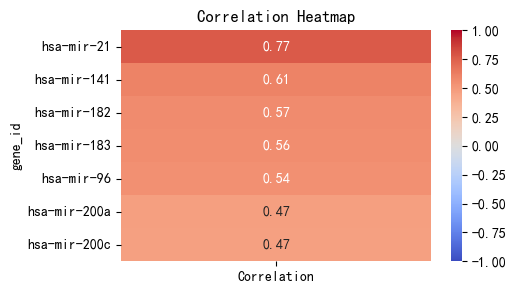

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create the dataframe
#data = {
#    'gene_id': ['hsa-mir-200c', 'hsa-mir-374a', 'hsa-mir-92a-1', 'hsa-mir-92a-2', 'hsa-mir-26a-1', 'hsa-mir-26a-2'],
#    'Correlation': [0.771453, 0.665850, 0.665658, 0.665600, 0.656800, 0.656040]
#}
data = {
    'gene_id': ['hsa-mir-21', 'hsa-mir-141', 'hsa-mir-182', 'hsa-mir-183', 'hsa-mir-96', 'hsa-mir-200a', 'hsa-mir-200c'],
    'Correlation': [0.769929, 0.606017, 0.567278, 0.558646, 0.544272, 0.474289, 0.468212]
}
df = pd.DataFrame(data)

# Set the gene_id as index
df.set_index('gene_id', inplace=True)

# Plot the heatmap with color limits from -1 to +1
plt.figure(figsize=(5, 3))
sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

# Show the plot
plt.title("Correlation Heatmap")
plt.show()



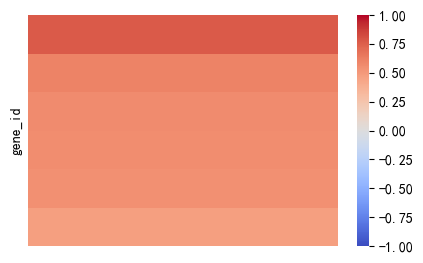

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create the dataframe
#data = {
#    'gene_id': ['hsa-mir-200c', 'hsa-mir-374a', 'hsa-mir-92a-1', 'hsa-mir-92a-2', 'hsa-mir-26a-1', 'hsa-mir-26a-2'],
#    'Correlation': [0.771453, 0.665850, 0.665658, 0.665600, 0.656800, 0.656040]
#}
data = {
    'gene_id': ['hsa-mir-21', 'hsa-mir-141', 'hsa-mir-182', 'hsa-mir-183', 'hsa-mir-96', 'hsa-mir-200a', ],
    'Correlation': [0.769929, 0.606017, 0.567278, 0.558646, 0.544272, 0.474289]
}
df = pd.DataFrame(data)

# Set the gene_id as index
df.set_index('gene_id', inplace=True)

# Plot the heatmap without annotations, but keep the colorbar
plt.figure(figsize=(5, 3))
sns.heatmap(df, annot=False, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

# Remove ticks and labels
plt.xticks([])
plt.yticks([])

# Show the plot without title and annotations but with the colorbar
plt.show()
